In [1]:
import matplotlib.pyplot as plt
import openturns as ot
import numpy as np
from scipy.optimize import minimize, Bounds, LinearConstraint, approx_fprime
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

%matplotlib widget

In [2]:
def npmap2d(fun, xs, ys, multi_output=False):
    """
    #https://stackoverflow.com/questions/22774726/numpy-evaluate-function-on-a-grid-of-points
    Evaluate a function on a grid of points.

    Parameters:
        fun (callable): The function to evaluate.
        xs (array_like): 1-D array of x-coordinates.
        ys (array_like): 1-D array of y-coordinates.
        fun_arg (int, optional): Index of the function output to return (default: None).

    Returns:
        X (ndarray): 2-D array of x-coordinates.
        Y (ndarray): 2-D array of y-coordinates.
        Z (ndarray): 2-D array of function values.
    """
    # Create 2D grid of x and y coordinates
    X, Y = np.meshgrid(xs, ys)

    # Evaluate the function on the grid
    Z_results = [fun([x, y]) for x, y in tqdm(zip(X.flat, Y.flat), total=X.size, desc='Progress')]

    if not multi_output:
        Z = np.array(Z_results).reshape(X.shape)
    else :
        Z = list(zip(*Z_results))
    
    return X, Y, Z

#### Lois + échantillons

In [3]:
X1 = ot.Normal(0,1)
X2 = ot.Normal(0,1)
X3 = ot.Normal(0,1)
X4 = ot.Normal(0,1)

N=int(1e6)
smpX1 = np.array(X1.getSample(N))
smpX2 = np.array(X2.getSample(N))
smpX3 = np.array(X3.getSample(N))
smpX4 = np.array(X4.getSample(N))

smpX1X2 = np.hstack([smpX1,smpX2])
smpX1X2X3X4 = np.hstack([smpX1,smpX2,smpX3,smpX4])

t1_0 = -1
t2_0 = -1

tol=1e-12

In [4]:
def limit_state_function(smpX1, smpX2):
    return (1.- np.where(smpX1>0,1,0)*np.where(smpX2>0,1,0)*np.where(smpX2+smpX1-3<0,1,0)) 

In [5]:
def gaussian_log_gradient_mean(sample, mean, standard):
    return (1/standard)*((sample-mean)/standard)

def gaussian_log_gradient_standard(sample, mean, standard):
    return (1/standard)*(np.square((sample-mean)/standard) - 1)

def intermediate_lambda_function(lambdas):
    return np.sqrt(lambdas)

def intermediate_lambda_function_derivate(lambdas):
    return 1/(2*np.sqrt(lambdas))

def lambda_sigma_compose(lambdas, ref_samples):
    return ref_samples*lambdas[np.newaxis, :]

def lambda_mu_compose(lambdas, ref_samples):
    return ref_samples + lambdas[np.newaxis, :]

def monte_carlo_performance_function(defect_samples):
    return limit_state_function(defect_samples[:,0], defect_samples[:,1])

def monte_carlo_performance_function_non_compliancy_at_threshold(compliancy_threshold, performance_function_sample):
    return np.where(performance_function_sample<=compliancy_threshold,1,0)

def monte_carlo_non_compliancy_rate_gradient(ref_samples_composed, non_compliancy_monte_carlo_sample, means_composed, standards_composed):
    gradients = np.multiply(non_compliancy_monte_carlo_sample[:, np.newaxis], gaussian_log_gradient_standard(ref_samples_composed, means_composed, standards_composed))
    return gradients.mean(axis=0)

def monte_carlo_non_compliancy_rate_gradient_start_space(lambdas, gradient_composed):
    return intermediate_lambda_function_derivate(lambdas) * gradient_composed 

def monte_carlo_non_compliancy_rate(non_compliancy_monte_carlo_sample):
    return non_compliancy_monte_carlo_sample.mean()

def monte_carlo_non_compliancy_rate_at_threshold_w_gradient(compliancy_threshold, lambdas, ref_samples, ref_means, ref_standards):
    lambdas_sqrt                        = intermediate_lambda_function(lambdas)
    standards_composed                  = np.multiply(lambdas_sqrt, ref_standards)
    means_composed                      = np.multiply(lambdas_sqrt, ref_means)
    reference_samples_composed          = lambda_sigma_compose(lambdas_sqrt, ref_samples = ref_samples)
    performance_function_sample         = monte_carlo_performance_function(reference_samples_composed)
    non_compliancy_sample               = monte_carlo_performance_function_non_compliancy_at_threshold(compliancy_threshold, performance_function_sample)
    non_compliancy_gradient             = monte_carlo_non_compliancy_rate_gradient(reference_samples_composed, non_compliancy_sample, means_composed, standards_composed)
    non_compliancy_gradient_start_space = monte_carlo_non_compliancy_rate_gradient_start_space(lambdas, non_compliancy_gradient)
    non_compliancy_rate                 = monte_carlo_non_compliancy_rate(non_compliancy_sample)
    return non_compliancy_rate, -non_compliancy_gradient_start_space

def monte_carlo_non_compliancy_rate_w_gradient(compliancy_threshold):
    return partial(monte_carlo_non_compliancy_rate_at_threshold_w_gradient, compliancy_threshold)

In [6]:
def event_probability_gradient(t,X1=smpX1,X2=smpX2,N=N):
    smpX1 = X1 + t[0]
    smpX2 = X2 + t[1]
    non_compliancy_sample = (1.- np.where(smpX1>0,1,0)*np.where(smpX2>0,1,0)*np.where(smpX2+smpX1-3<0,1,0)) 
    pX1X2neg = non_compliancy_sample.mean()
    
    gradt0 = (non_compliancy_sample*gaussian_log_gradient_mean(smpX1,t[0], 1)).mean()
    gradt1 = (non_compliancy_sample*gaussian_log_gradient_mean(smpX2,t[1], 1)).mean()
    return pX1X2neg, np.array([gradt0, gradt1])

def event_probability_gradient_linked_inputs(t,X1=smpX1,X2=smpX2,N=N):
    smpX1 = X1 + t[0]
    smpX2 = X2 + 1/t[0]
    non_compliancy_sample = (1.- np.where(smpX1>0,1,0)*np.where(smpX2>0,1,0)*np.where(smpX2+smpX1-3<0,1,0)) 
    pX1X2neg = non_compliancy_sample.mean()
    
    gradt0 = (non_compliancy_sample*gaussian_log_gradient_mean(smpX1,t[0], 1)).mean()
    gradt1 = (non_compliancy_sample*gaussian_log_gradient_mean(smpX2,1/t[0], 1)).mean()

    grad_tot = gradt0 - (1/(t[0]**2))*gradt1
    return pX1X2neg, np.array([grad_tot])

def event_probability(t,X1=smpX1,X2=smpX2,N=N):
    smpX1 = X1 + t[0]
    smpX2 = X2 + 1/t[0]
    non_compliancy_sample = (1.- np.where(smpX1>0,1,0)*np.where(smpX2>0,1,0)*np.where(smpX2+smpX1-3<0,1,0)) 
    pX1X2neg = non_compliancy_sample.mean()
    return pX1X2neg

def event_probability_gradient2(t,X1=smpX1,X2=smpX2,N=N):
    smpX1 = X1 + t[0]
    smpX2 = X2 + t[1]
    non_compliancy_sample = np.squeeze(1.- np.where(smpX1>0,1,0)*np.where(smpX2>0,1,0)*np.where(smpX2+smpX1-3<0,1,0)) 
    pX1X2neg = non_compliancy_sample.mean()
    gradient = np.multiply(non_compliancy_sample[:, np.newaxis], gaussian_log_gradient_mean(smpX1X2, t, np.array([1,1])))
    return pX1X2neg, gradient.mean(axis=0)

In [7]:
grid = (np.arange(1000)*4)/1000 + tol
result = list()
result = Parallel(n_jobs=-2)(delayed(event_probability_gradient_linked_inputs)([pnt]) for pnt in tqdm(grid))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [8]:
failure_probs, grads = list(zip(*result))
failure_probs = np.array(failure_probs)

In [9]:
1/grid[5]

49.999999997500005

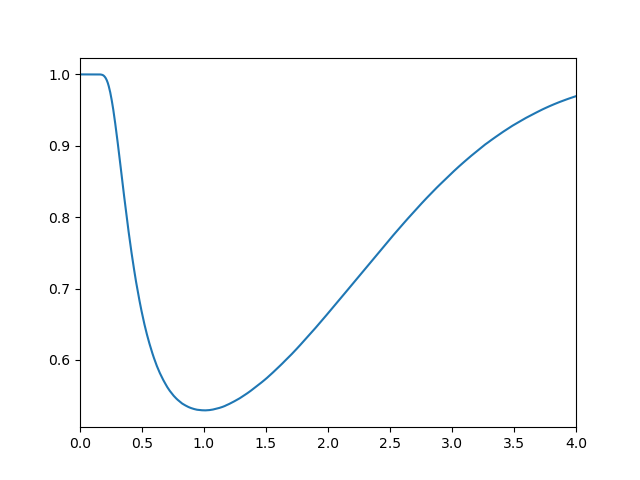

In [10]:
ax = plt.subplot()
ax.set_xlim(0,4)
ax.plot(grid, failure_probs)

In [11]:
ax = plt.subplot()
ax.set_xlim(0,4)
ax.plot(grid[5:], grads[5:])

In [12]:
f_prime_1_order = (failure_probs[1:]-failure_probs[:-1])/(grid[1:]-grid[:-1])
f_prime_2_order = (failure_probs[2:]-failure_probs[:-2])/(grid[2:]-grid[:-2])

In [13]:
ax = plt.subplot()
ax.set_xlim(0,4)
ax.plot(grid[:-1], f_prime_1_order)

In [14]:
ax = plt.subplot()
ax.set_xlim(0,4)
ax.plot(grid[:-2], f_prime_2_order)

In [15]:
bounds=Bounds([tol], [10])

In [16]:
minimize(event_probability_gradient,[t1_0, t2_0], args=(smpX1,smpX2,N), jac=True, method="SLSQP")

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.528696
       x: [ 9.621e-01  9.569e-01]
     nit: 6
     jac: [ 1.035e-04 -3.312e-04]
    nfev: 7
    njev: 6

In [17]:
minimize(event_probability_gradient_linked_inputs,[2.5], args=(smpX1,smpX2,N), jac=True, method="SLSQP", bounds=bounds)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.529387
       x: [ 1.007e+00]
     nit: 10
     jac: [ 2.777e-03]
    nfev: 20
    njev: 10

In [18]:
tol = 0.05 #1e-12
grid_size = 25
l1_vals = np.linspace(tol,1-tol,grid_size)
l2_vals = np.linspace(tol,1-tol,grid_size)
grid = np.meshgrid(l1_vals, l2_vals, indexing='xy')

In [19]:
X, Y, Z = npmap2d(event_probability_gradient, l1_vals, l2_vals, multi_output=True)

Progress:   0%|          | 0/625 [00:00<?, ?it/s]

In [20]:
lambda_probability = np.array(Z[0]).reshape(X.shape)
lambda_probability_gradient = np.stack(Z[1])

In [21]:
lambda_probability_gradient_lambda1 = lambda_probability_gradient[:,0].reshape(X.shape)
lambda_probability_gradient_lambda2 = lambda_probability_gradient[:,1].reshape(X.shape)
gradient_w_placeholder = np.zeros(lambda_probability_gradient_lambda2.shape)

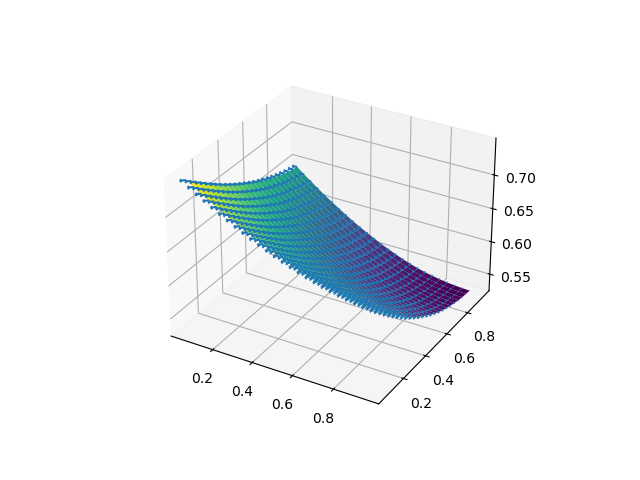

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, lambda_probability, cmap='viridis')
gradient = ax.quiver(X, Y, lambda_probability, lambda_probability_gradient_lambda1, lambda_probability_gradient_lambda2, gradient_w_placeholder, length=0.1, normalize=False)

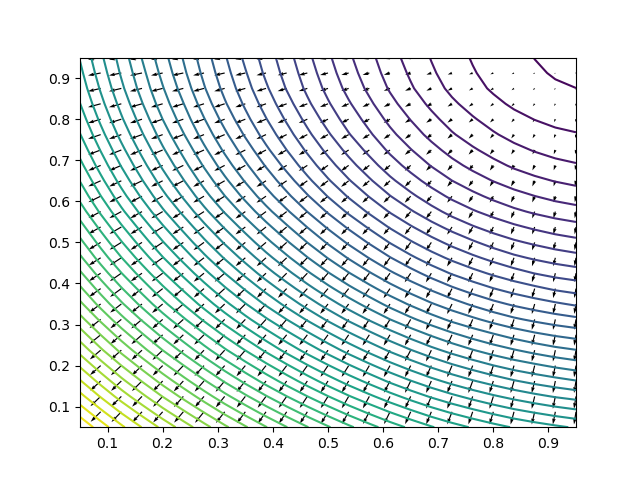

In [23]:
fig = plt.figure()
surf = plt.contour(X, Y, lambda_probability, 50,cmap='viridis')
gradient = plt.quiver(X, Y, lambda_probability_gradient_lambda1, lambda_probability_gradient_lambda2)

In [24]:
def event_probability(t,X1=smpX1,X2=smpX2,N=N):
    smpX1 = X1 + t[0]
    smpX2 = X2 + t[1]
    pX1X2neg = 1.- (np.where(smpX1>0,1,0)*np.where(smpX2>0,1,0)*np.where(smpX2+smpX1-3<0,1,0)).mean()
    return pX1X2neg;

In [25]:
def gradient_event_probability_analytical(t, X1=smpX1,X2=smpX2,N=N):
    gradt0 = ((np.where(smpX1<=0,1,0) | np.where(smpX2<=0,1,0) | np.where(smpX2+smpX1-3>=0,1,0))*gaussian_log_gradient_mean(smpX1,t[0])).mean()
    gradt1 = ((np.where(smpX1<=0,1,0) | np.where(smpX2<=0,1,0) | np.where(smpX2+smpX1-3>=0,1,0))*gaussian_log_gradient_mean(smpX2,t[1])).mean()
    return [gradt0, gradt1];